In [1]:
import numpy as np
import matplotlib.pyplot as plt

from covapt_mt.covapt import covariance_model

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pk_galaxy_file = "/home/joeadamo/Research/SPHEREx/spherex_emu/data/ps_eft_fid.npy"
n_galaxy = np.array([1e-4, 1e-4])

model = covariance_model(0.61, n_galaxy)
model.load_power_spectrum(pk_galaxy_file)

print(model.pk_galaxy.shape)

(2, 2, 2, 5, 25)


In [7]:
C_G = model.get_mt_gaussian_covariance()
P_G = np.zeros_like(C_G)
for z in range(model.num_zbins):
    P_G[z] = np.linalg.inv(C_G[z])

In [4]:
def CorMat(cov):
    rms = np.sqrt(np.diag(cov))
    cor = np.copy(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            cor[i,j] = cov[i,j]/(rms[i]*rms[j])
    return cor

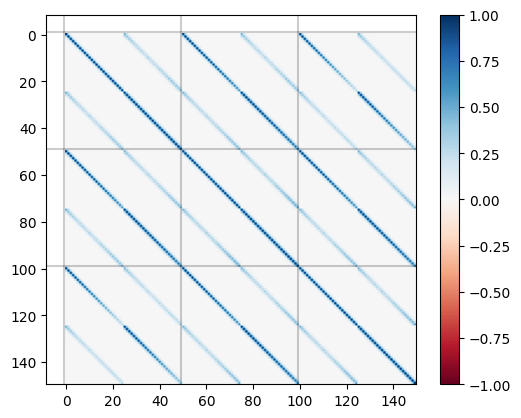

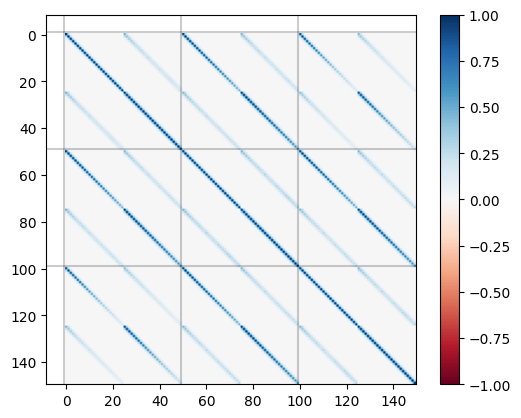

In [5]:
for z in range(model.num_zbins):

    try:
        L = np.linalg.cholesky(C_G[z])
    except:
        print("ERROR! Covariance matrix is not positive definite!")
        
    plt.figure()
    corr = CorMat(C_G[z])
    img = plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
    for i in range(model.num_spectra):
        plt.axvline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
        plt.axhline(i*model.num_kbins*2 - 1, c="black", alpha=0.2)
    plt.colorbar()

In [8]:
np.save("/home/joeadamo/Research/SPHEREx/spherex_emu/data/cov_2_sample_2_redshift/cov.npy", C_G)
np.save("/home/joeadamo/Research/SPHEREx/spherex_emu/data/cov_2_sample_2_redshift/invcov.npy", P_G)

In [11]:
import torch
invcov_pytorch = torch.from_numpy(P_G)

np.save("/home/joeadamo/Research/Data/SPHEREx-Data/Training-Set-EFT-2s-2z/invcov.dat", invcov_pytorch)